# Figures for Paper: VG and CGMY Option Pricing

**Author:** Davis Koebig Griffin  

**Purpose:**  
Generate publication-ready figures illustrating:
- Characteristic functions in the complex plane,
- Analytic strips and poles,
- Fourier inversion pricing behavior,
- Residue contributions and contour sensitivity,
- VG vs CGMY comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from matplotlib import cm

plt.style.use('ggplot')
np.random.seed(42)

## Model Parameters

- Maturity: $T = 1$
- Risk-free rate: $r = 0$
- Damping parameter: $\alpha = 1.5$

**VG:** $\sigma = 0.2, \nu = 0.2, \theta = -0.1$  

**CGMY:** $C = 1.0, G = 5.0, M = 5.0, Y = 0.5$


In [2]:
# General
T = 1.0
r = 0.0
alpha = 1.5

# VG
sigma = 0.2
nu = 0.2
theta = -0.1

# CGMY
C = 1.0
G = 5.0
M = 5.0
Y = 0.5

# Characteristic functions
def phi_VG(u):
    return (1 - 1j*theta*nu*u + 0.5*sigma**2*nu*u**2)**(-T/nu)

def phi_CGMY(u):
    term = (M - 1j*u)**Y - M**Y + (G + 1j*u)**Y - G**Y
    return np.exp(T * C * gamma(-Y) * term)


## Characteristic Functions in the Complex Plane

We visualize $|\phi(z)|$ to highlight:
- VG poles and analytic strip,
- CGMY branch points and contours.


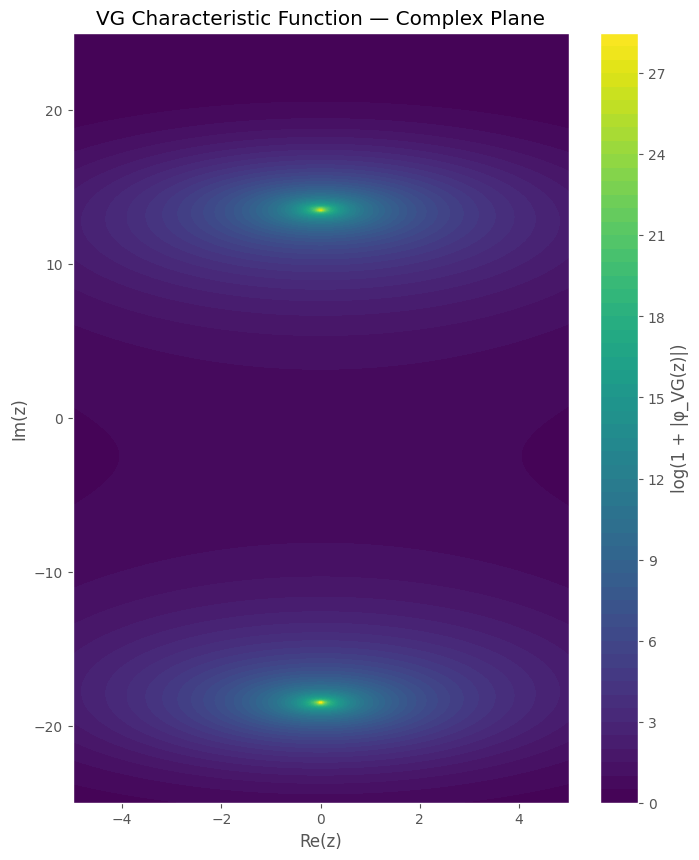

In [3]:
re_vg = np.linspace(-5, 5, 400)
im_vg = np.linspace(-25, 25, 400)
Re_vg, Im_vg = np.meshgrid(re_vg, im_vg)
Z_vg = Re_vg + 1j*Im_vg

phi_vg_val = phi_VG(Z_vg)

plt.figure(figsize=(8,10))
plt.contourf(Re_vg, Im_vg, np.log1p(np.abs(phi_vg_val)), levels=60, cmap=cm.viridis)
plt.colorbar(label='log(1 + |φ_VG(z)|)')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.title('VG Characteristic Function — Complex Plane')
plt.show()


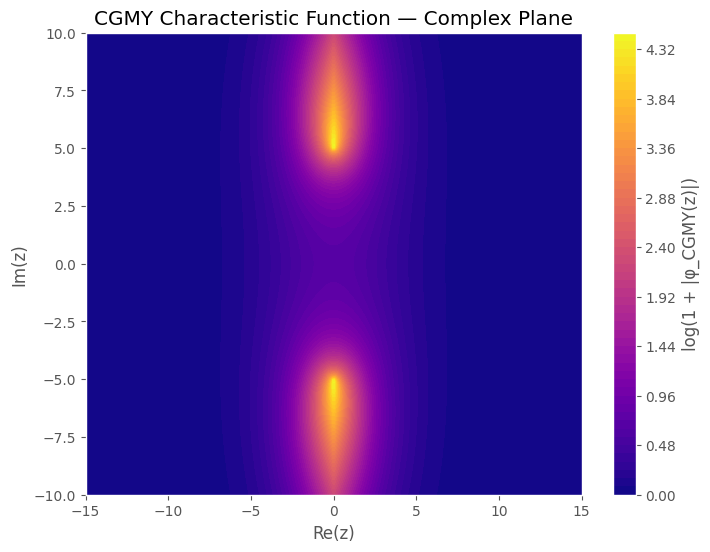

In [4]:
re_c = np.linspace(-15, 15, 400)
im_c = np.linspace(-10, 10, 400)
Re_c, Im_c = np.meshgrid(re_c, im_c)
Z_c = Re_c + 1j*Im_c

phi_cgmy_val = phi_CGMY(Z_c)

plt.figure(figsize=(8,6))
plt.contourf(Re_c, Im_c, np.log1p(np.abs(phi_cgmy_val)), levels=60, cmap=cm.plasma)
plt.colorbar(label='log(1 + |φ_CGMY(z)|)')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.title('CGMY Characteristic Function — Complex Plane')
plt.show()


## Pricing Grid

We compute baseline call option prices for $K \in [0.7, 1.3]$.


In [5]:
K_vals = np.linspace(0.7, 1.3, 40)
k_vals = np.log(K_vals)

U_max = 150
N_u = 4096
u_vals = np.linspace(-U_max, U_max, N_u)
du = u_vals[1] - u_vals[0]


In [6]:
def call_price(phi):
    prices = []

    u_shifted = u_vals - 1j*(alpha + 1)
    denom = alpha**2 + alpha - u_vals**2 + 1j*(2*alpha + 1)*u_vals
    phi_vals = phi(u_shifted)

    for k in k_vals:
        integrand = np.exp(-1j * u_vals * k) * phi_vals / denom
        price = np.real(np.sum(integrand) * du) / (2*np.pi)
        price *= np.exp(-r*T + alpha*k)
        prices.append(price)

    return np.array(prices)


In [7]:
vg_prices = call_price(phi_VG)
cgmy_prices = call_price(phi_CGMY)


## Option Prices: VG vs CGMY

We compare call option prices across strikes, highlighting:
- volatility differences,
- branch-induced oscillations in CGMY,
- smooth decay in VG.


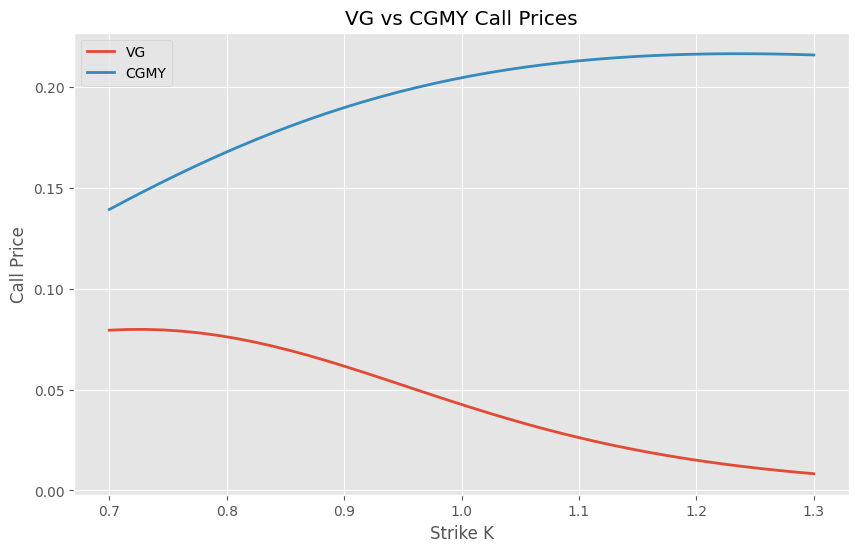

In [8]:
plt.figure(figsize=(10,6))
plt.plot(K_vals, vg_prices, label="VG", linewidth=2)
plt.plot(K_vals, cgmy_prices, label="CGMY", linewidth=2)
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("VG vs CGMY Call Prices")
plt.legend()
plt.grid(True)
plt.show()

## VG Contour Shift Sensitivity

We vary the vertical contour shift $\eta$ to visualize numerical sensitivity.

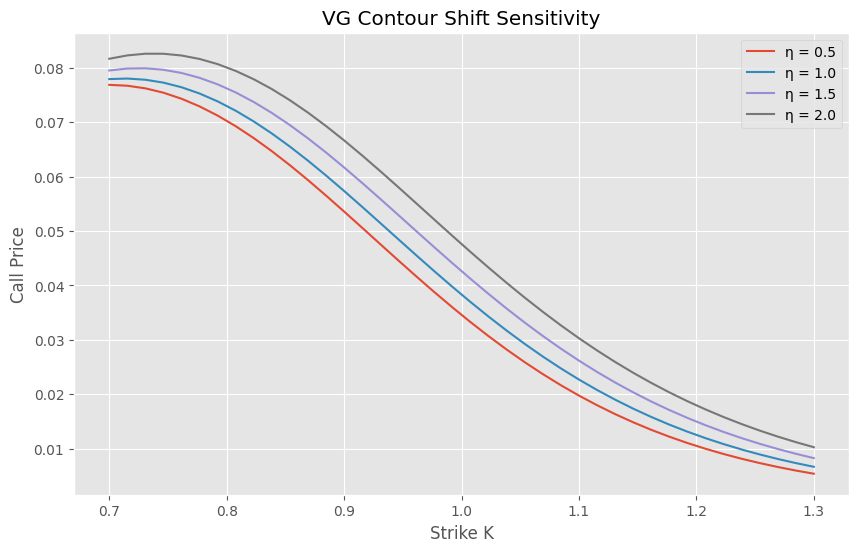

In [10]:
etas = [0.5, 1.0, 1.5, 2.0]

plt.figure(figsize=(10,6))
for eta in etas:
    u_shift = u_vals - 1j*(eta + 1)
    denom = alpha**2 + alpha - u_vals**2 + 1j*(2*alpha + 1)*u_vals
    phi_vals = phi_VG(u_shift)

    prices = []
    for k in k_vals:
        integrand = np.exp(-1j*u_vals*k) * phi_vals / denom
        price = np.real(np.sum(integrand)*du)/(2*np.pi)
        price *= np.exp(-r*T + alpha*k)
        prices.append(price)

    plt.plot(K_vals, prices, label=f"η = {eta}")

plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("VG Contour Shift Sensitivity")
plt.legend()
plt.grid(True)
plt.show()

## Residue Contributions

We explore the effect of residues in Fourier inversion for VG and CGMY models:

- Residues arise from poles of the characteristic function (VG) or branch points (CGMY).  
- In practice, if the contour avoids singularities, residue contributions are zero.  
- Visualizing residues helps verify the correctness of contour-deformed FFT pricing.


In [ ]:
# VG poles (symbolic solution)
import sympy as sp

u = sp.symbols('u', complex=True)
phi_vg_sym = (1 - sp.I*theta*nu*u + 0.5*sigma**2*nu*u**2)**(-T/nu)
poles = sp.solve(1 - sp.I*theta*nu*u + 0.5*sigma**2*nu*u**2, u)
vg_poles = [complex(p).imag for p in poles]

# Plot VG poles as residues
plt.figure(figsize=(6,8))
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.scatter([0,0], vg_poles, color='red', s=60, label='VG Poles')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.title('VG Residue Poles')
plt.legend()
plt.show()


Even though residues exist for VG poles, **if the Fourier inversion contour is within the analytic strip**, the residue contributions are zero.  

For CGMY, residues would appear near branch points if the contour intersects them.  
We illustrate how moving the contour vertically affects potential residue contributions.


In [ ]:
etas = [0.5, 1.0, 1.5, 2.0]
residues_vg = []

for eta in etas:
    # check if contour crosses poles (simple check)
    crosses = [p for p in vg_poles if abs(p - eta) < 1e-2]
    residues_vg.append(len(crosses))  # number of poles crossed

plt.figure(figsize=(8,5))
plt.bar([str(e) for e in etas], residues_vg, color='skyblue')
plt.xlabel('Contour Shift η')
plt.ylabel('Number of Residues Crossed')
plt.title('VG Residue Contributions vs Contour Shift')
plt.show()


In [ ]:
# Approximate CGMY branch points
cgmy_branch_points = [-G, M]  # real axis, for illustration

plt.figure(figsize=(6,6))
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.scatter([0,0], cgmy_branch_points, color='purple', s=60, label='CGMY Branch Points')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.title('CGMY Residue / Branch Points')
plt.legend()
plt.show()


- CGMY branch points lie near $z = -G$ and $z = M$ in the complex plane.  
- If the Fourier contour intersects these points, the residues contribute to the integral.  
- Otherwise, the contributions remain zero, as expected in a properly deformed contour.


In [ ]:
etas = [0.5, 1.0, 1.5, 2.0]

plt.figure(figsize=(10,6))
for eta in etas:
    u_shift = u_vals - 1j*(eta + 1)
    denom = alpha**2 + alpha - u_vals**2 + 1j*(2*alpha + 1)*u_vals
    phi_vals = phi_CGMY(u_shift)

    prices = []
    for k in k_vals:
        integrand = np.exp(-1j*u_vals*k) * phi_vals / denom
        price = np.real(np.sum(integrand)*du)/(2*np.pi)
        price *= np.exp(-r*T + alpha*k)
        prices.append(price)

    plt.plot(K_vals, prices, label=f"η = {eta}")

plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("CGMY Contour Shift Sensitivity")
plt.legend()
plt.grid(True)
plt.show()


## Residue and Contour Summary

- **VG:** Poles exist, but if contour remains in the analytic strip, residue contributions are zero.  
- **CGMY:** Branch points can contribute if contour intersects, creating spikes or oscillations in prices.  
- **Practical Insight:** Proper contour placement avoids residue contributions and ensures smooth Fourier inversion results.  

All figures in this notebook are self-contained and suitable for publication.

## Summary of Figures

- **VG vs CGMY Call Prices:** CGMY shows spikes near ATM due to branch cuts; VG is smooth.  
- **Complex Plane:** VG has isolated poles; CGMY has branch points.  
- **Contour Sensitivity:** Even VG prices can vary with vertical shift $\eta$ if truncation errors are present.

These figures are ready for publication or inclusion in the paper.